# **BUSI 488 / COMP 488 Data Science in the Business World**
## *Spring 2023*  
Daniel M. Ringel  
Kenan-Flagler Business School  
*The University of North Carolina at Chapel Hill*  
dmr@unc.edu

## Class12 - Predictive Modelling: *Prediciting Real-estate Prices with Supervised Learning*

*February 23, 2023*  
Version 1.7

# Today's Agenda

1. **Supevised Machine Learning**   

2. **Predicting Housing Prices**  
    ●  Data Pre-Processing  
    ●  EDA: Visual Inspection of the Data 

3. **Regression Analysis for Prediction**  
    ● Linear Regression  
    ● Model Performance 
    ● Refining the Model  

4. **Regularization**  
    ● RIDGE Regression   
    ● LASSO Regression 

5. **Different Model: K-Nearest Neightboorhood Regression**  
    ● Model Baseline   
    ● Location only


## Prep-Check:
- **Took Quiz 2** before Sunday (02/19) midnight
- Report **DataCamp Homework 5** XP by midnight tonight

# 1. **Supervised Machine Learning**: Predictions from data with *labels* and *features*  
- Recommendation systems
- Email subject optimization
- Churn prediction

![Overview Machine Learning](https://www.cognub.com/wp-content/uploads/2016/02/1.png)
*Source: COGNUB 2016*

***X's and Y's***: 
* Unsupervised Learning operates on X's only (i.e., features)
* Supervised Learning requires X's (features) and Y's (labels)


##### **Hint:** Many Names, same thing:

- Features = predictor variables = independent variables = X's
- Target variable = dependent variable = response variable = labels = Y

##### **Important Concept:** We can think of all features (i.e., columns) of an observation (i.e., row) as a ***feature vector*** (of that observation). 
- At this point in the course, these features are structured data that are directly interpretable.   
- Later in this course, we will work with ***latent feature vectors*** where features are encoded (or embedded) in vectors. These latent features are not directly intepretable, but are very useful in dimensionality reduction, natural language processing, and AI applications in general. 
- You can think of a ***latent feature vector*** as a row (i.e., an observation) with many columns that contain numbers. The meaning of those numbers is, however, not immediately apparent. Yet, there is information embedded in these latent feature vectors that can be of interest/value to us.

In [1]:
# We first import a number of libraries that we will be using in today's class
import pandas as pd
import numpy as np

# Plotting packages we'll use
import matplotlib.pyplot as plt
import seaborn as sns

# Rather than importing the whole sklearn library, we will import only certain modules 
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn import metrics, model_selection
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV

# 2. The Data: Housing Prices in California

In today's class we explore a public dataset on median house prices in blocks in California that can be found already split into training and test sets on your Google Drive in sample_data.  (Information on the original source: https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html)
We'll use a version from the book Hands on Machine Learning by Aurelien Geron, since it adds a category feature, ocean_proximity.

**Today's objective** is to predict housing prices accurately and explore which factors contribute to them most.  

We load the data set below and display a description of the variables.   

**?** Which factors do you think will influence house prices upward and downward? 

In [2]:
# 1. Connect your Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
# 2. Change path to where the class files are: Let's assume you've created a folder 488 on your Google drive where you download Class folders from Canvas
%cd /content/gdrive/MyDrive/488/Class12
# 3. Look what's in the folder
!ls

Mounted at /content/gdrive
/content/gdrive/MyDrive/488/Class12
488_2023_Class12.ipynb	housing.csv


## 2.1 Read data into a single data frame
Later we will split out the features X from target y = `median_house_value`

In [3]:
# 1. Read file into a dataframe
df = pd.read_csv("housing.csv")
# 2. Check rows and columns
print(df.shape)
# 3. output first 5 observations
df.head()

(20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## 2.2 Explore Numerical and Categorical Data
With the data collected, it will make sense to do some **feature engineering** -- making new columns by calculations on input columns


### 2.2.1 Numerical data

* `describe()` shows the numeric features, and lists `count`, or number of data entries, the `mean` value, and the `standard deviation`, `min`, `max` and `quartile` values. 
* The ranges of feature values differ quite a lot, so we can start to think about whether to normalize, or to eliminate outliers. 
* We'll want to make some new per capita or per household features that are more comparable across blocks with different populations. 
* We'll use histograms and boxplots to summarize the feature distributions, using the low-level matplotlib to start with. By wrapping the plot code in a function, we can reapply it after changing variables. 


In [4]:
# 1. Get some summary statistics
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


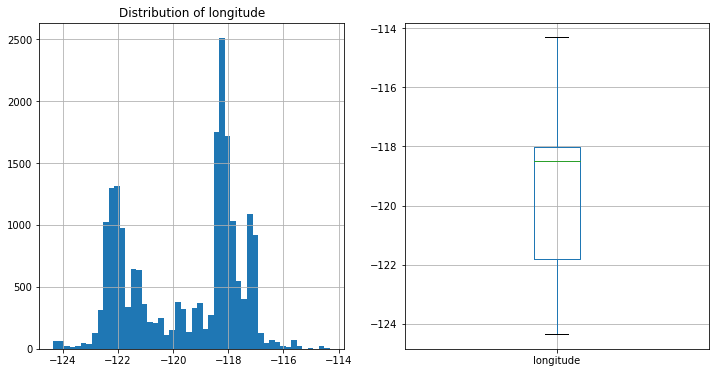

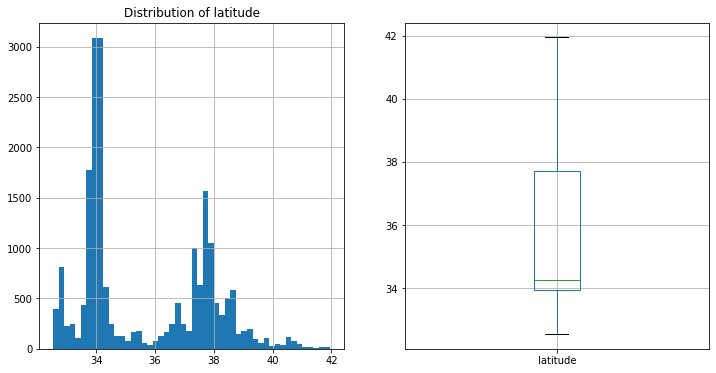

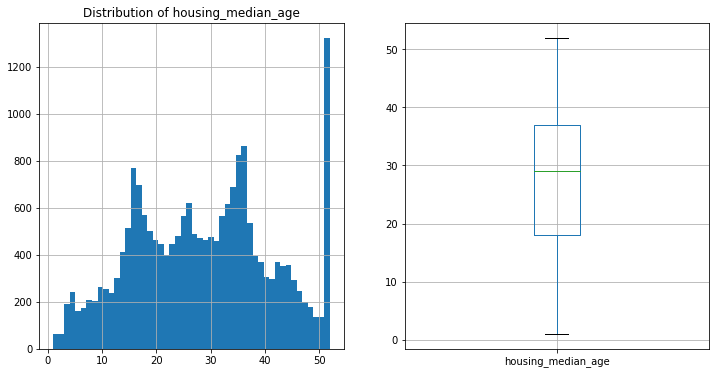

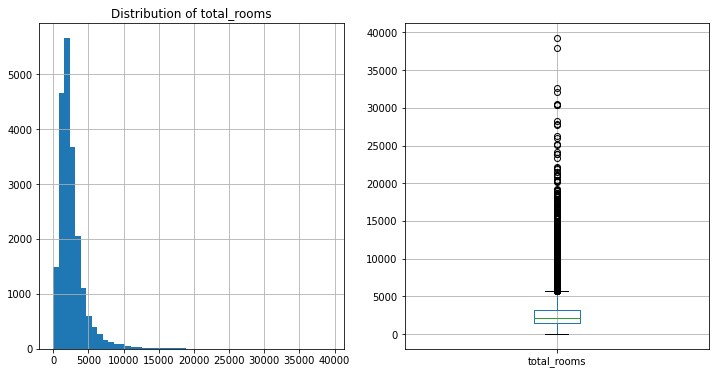

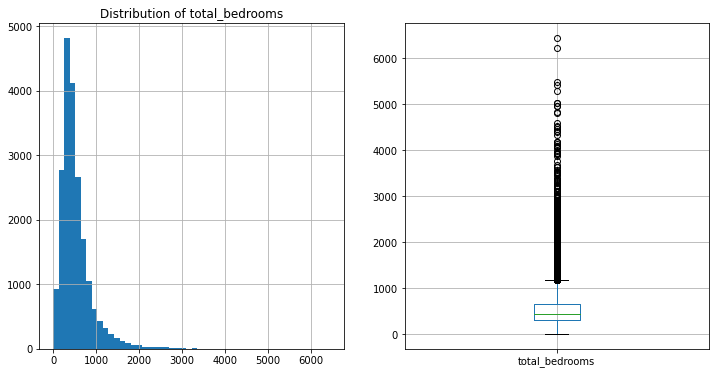

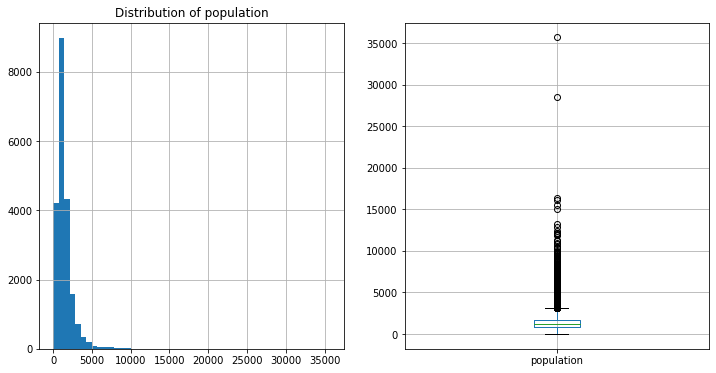

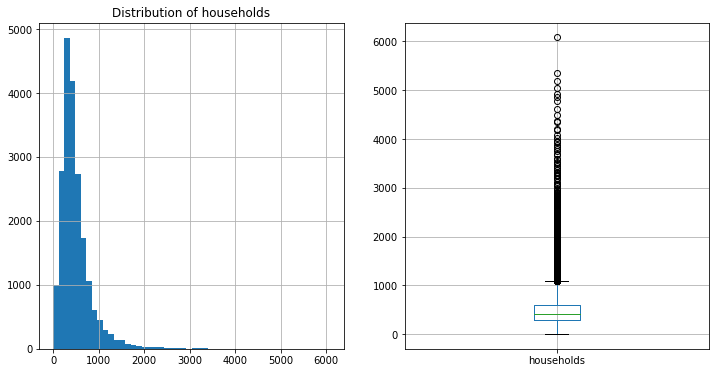

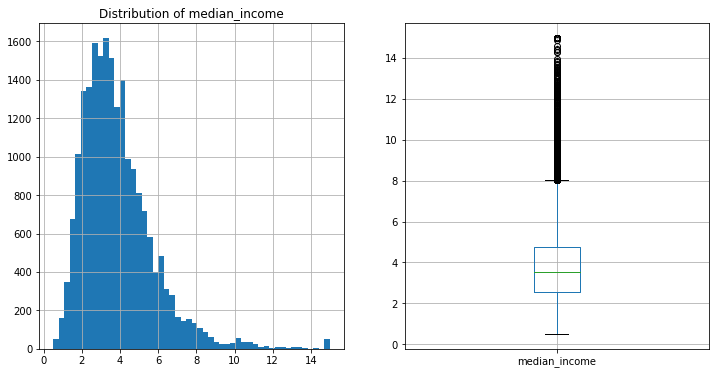

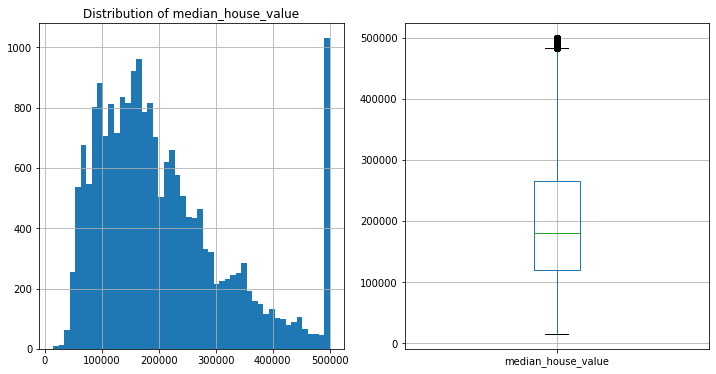

In [5]:
# 2. Define a function that creates histograms and boxplots for all numerical variables
def plot_numerics(df): # we loop through all the numeric columns
  for col in df.columns:
    if df[col].dtype == 'float64':
      # and for each column we create space for one row with 2 charts 
      f, axes = plt.subplots(1, 2, figsize=(12, 6))
      # our first chart is a histogram and we set the title 
      df[col].hist(bins = 50, ax = axes[0])
      axes[0].set_title('Distribution of '+ col)
      # our second column is the boxplot 
      df.boxplot(column = col, ax = axes[1])
      # we then use this command to display the charts
      plt.show()

# 3. Call function and pass our dataframe to it      
plot_numerics(df)

#### Recap:
* A `histogram` tells is the number of times, or frequency, a value occurs within a `bin`, or bucket, that splits the data (and which we defined). A histogram shows the frequency with which values occur within each of these bins, and can tell us about the distribution of data. 
* A `boxplot` captures within the box the `interquartile range`, the range of values from Q1/25th percentile to Q3/75th percentile, and the median value. It also captures the `min` and `max` values of each feature.
* Together, these charts show us the distribution of values for each feature. We can start to make judgements about how to treat the data, for example whether we want to deal with outliers; or whether we want to normalize the data.

### 2.2.2 Dealing with the category data
* `ocean_proximity` contains category data, so we convert it to category type.  
* We can then make a boxplot of the median_house_value by category: 
Inland houses clearly appear lower, and island higher, so this may be an important categorical variable. 
* On the other hand, we may want to drop the Island category data, since it is only 5 houses.

In [6]:
# 1. See how many observations we have per category
df.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
# 2. optional: drop ISLAND
df = df[df['ocean_proximity'] != 'ISLAND'] 
df.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
Name: ocean_proximity, dtype: int64

In [8]:
# 3. Typecast Ocean Proximity to categorical
df['ocean_proximity'] = df['ocean_proximity'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20635 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20635 non-null  float64 
 1   latitude            20635 non-null  float64 
 2   housing_median_age  20635 non-null  float64 
 3   total_rooms         20635 non-null  float64 
 4   total_bedrooms      20428 non-null  float64 
 5   population          20635 non-null  float64 
 6   households          20635 non-null  float64 
 7   median_income       20635 non-null  float64 
 8   median_house_value  20635 non-null  float64 
 9   ocean_proximity     20635 non-null  category
dtypes: category(1), float64(9)
memory usage: 1.6 MB


<ipython-input-8-91989d3b9c48>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ocean_proximity'] = df['ocean_proximity'].astype('category')


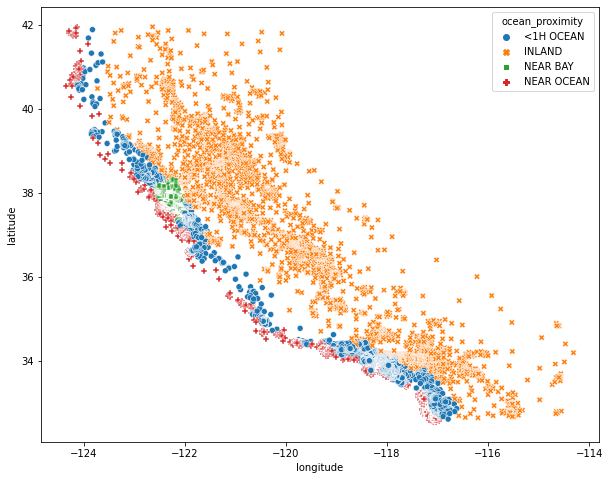

In [9]:
# 4. Seaborn can show us the shape of the data with a simple scatter plot
# and also apply categories to hue or style.  
plt.figure(figsize=(10,8))
sns.scatterplot(data=df, x='longitude', y='latitude', hue='ocean_proximity', style='ocean_proximity')
plt.show()

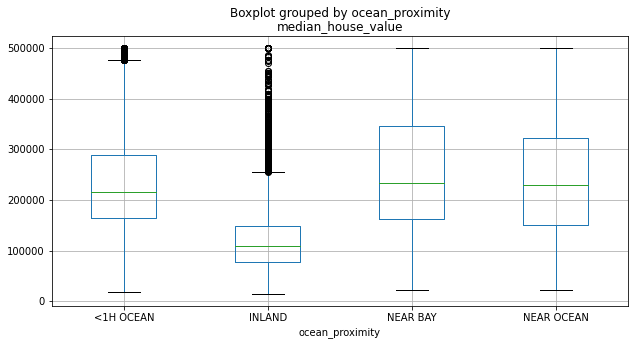

In [10]:
# 5. Let's plot values by category here
f, axes = plt.subplots(1, 1, figsize=(10, 5))   
df.boxplot(column='median_house_value', by = 'ocean_proximity', ax = axes)
plt.show()

### 2.2.3 Let's examine our response (or target) variable
* seaborn is a package on top of matplotlib that has a nicer color scheme and works with pandas to make some plots easier. Experiment with plots showing two columns together.
* It seems that blocks whose median house is over $500K were all lumped together.  If we want accurate predictions, we'll have to discard these as outliers. Similarly for houses over 50 years.  

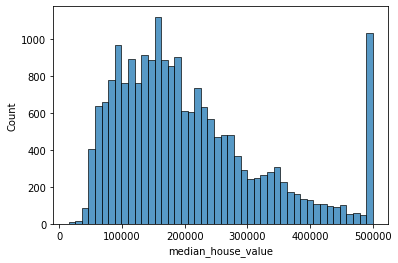

In [11]:
# 1. Let's visualize the distirubtions of some variables and variable combinations
sns.histplot(data=df, x='median_house_value') 
#sns.histplot(data=df, x='median_house_value', y='median_income') # try me
#sns.scatterplot(data=df, x='median_house_value', y='median_income') # try me
#sns.histplot(data=df[df.population>4000], x='median_house_value') #, y='population') # try me
#sns.histplot(data=df, x='median_house_value', y='housing_median_age') # try me
plt.show()

In [12]:
# 2. We can also look at the counts for each house value (is that really helpful?)
df['median_house_value'].value_counts()

500001.0    965
137500.0    122
162500.0    117
112500.0    103
187500.0     93
           ... 
54900.0       1
304200.0      1
377600.0      1
81200.0       1
47000.0       1
Name: median_house_value, Length: 3842, dtype: int64

### 2.2.4 Correlation and Multicollinearity 

We can generate a heatmap based on the correlation between features (and the response variable) to visually explore which features:  
- might be most relevant in explaining our response variable
- are strongly correlated so that we might not want to include them jointly in our predicition model

**?** What are the features that are most positively correlated?  Why should you not be surprised?

**?** What are the features that are most negatively correlated, and why?  

**?** What correlations with median_house_value are farthest from zero?  Are they what you would expect?

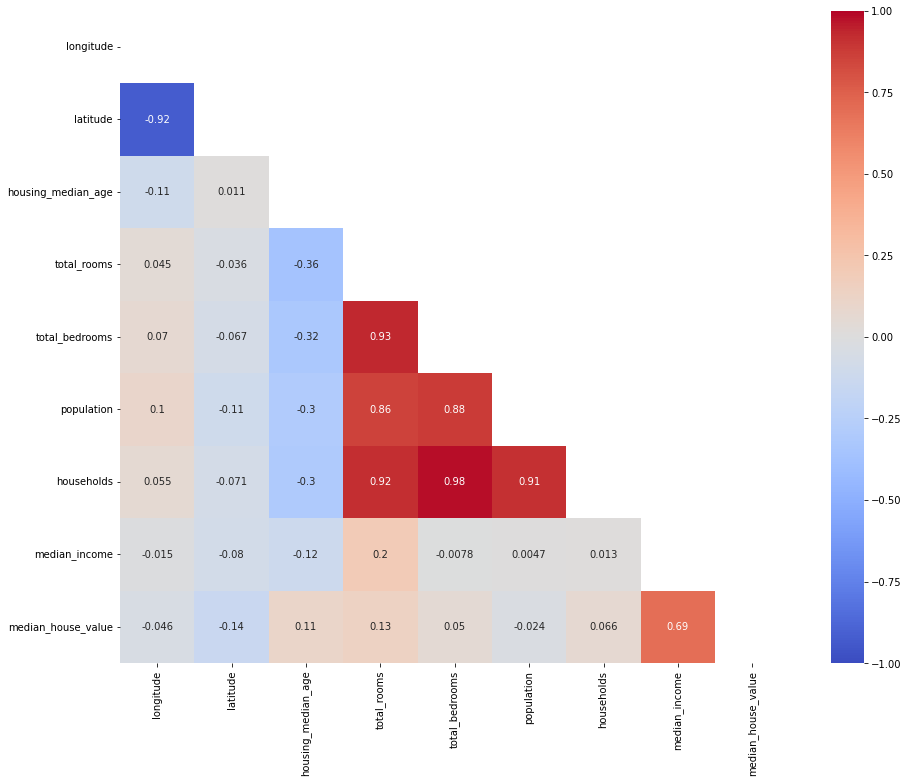

In [13]:
plt.figure(figsize=(15,12)) # if you need this correlation heatmap to be bigger
corr = df.corr()
sns.heatmap(corr,  vmin = -1, vmax = 1, center = 0, cmap = 'coolwarm', annot = True, 
            mask = np.triu(corr));  # masks upper part of triangle

## 2.3 Feature selection, feature transformation, and feature engineering
This is where you have chances to customize what features you want to consider in your model. 
* For a small number of records, `total_bedrooms` is not reported.  Since above we saw that 20% of `total_rooms` being bedrooms is typical for the other data, we can impute at this value. (What other ways might you consider imputing?)


* We can replace the category by "One-Hot Encoding". We make dummy or indicator variables for each possibility (1=in that category).  This takes memory, but allows these to be used as numbers in regression. 


* The numbers of rooms is closely correlated with population, but rooms per household or rooms per person might be more informative for house price. 


In [14]:
# 1. Missing data: replace nans in total_bedrooms by imputing them to be 20% of all rooms
df.loc[df['total_bedrooms'].isna(), 'total_bedrooms'] = 0.20*df['total_rooms']

In [15]:
# 2. Add indicator variables for the ocean_proximity values, except the first.
# (When no other is selected, then we know the first must have been selected.) 
df = pd.get_dummies(df, columns=['ocean_proximity'], prefix="prox", drop_first=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20635 entries, 0 to 20639
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20635 non-null  float64
 1   latitude            20635 non-null  float64
 2   housing_median_age  20635 non-null  float64
 3   total_rooms         20635 non-null  float64
 4   total_bedrooms      20635 non-null  float64
 5   population          20635 non-null  float64
 6   households          20635 non-null  float64
 7   median_income       20635 non-null  float64
 8   median_house_value  20635 non-null  float64
 9   prox_INLAND         20635 non-null  uint8  
 10  prox_NEAR BAY       20635 non-null  uint8  
 11  prox_NEAR OCEAN     20635 non-null  uint8  
dtypes: float64(9), uint8(3)
memory usage: 2.1 MB


In [16]:
# 3. Save before further feature engineering
df_preFE = df.copy() 

In [17]:
# 4. Engineer some new featurs that might be meaningful
# (Comment out or drop features you don't want to add)

df['Br/Rooms'] = df['total_bedrooms']/df['total_rooms']
#df['Rooms/person'] = df['total_rooms']/df['population']
df['Rooms/hhold'] = df['total_rooms']/df['households']
#df['Br/person'] = df['total_bedrooms']/df['population']
df['Br/hhold'] = df['total_bedrooms']/df['households']
df['pop/hhold'] = df['population']/df['households']

In [18]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,prox_INLAND,prox_NEAR BAY,prox_NEAR OCEAN,Br/Rooms,Rooms/hhold,Br/hhold,pop/hhold
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,1,0,0.146591,6.984127,1.023810,2.555556
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,1,0,0.155797,6.238137,0.971880,2.109842
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,1,0,0.129516,8.288136,1.073446,2.802260
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,1,0,0.184458,5.817352,1.073059,2.547945
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,1,0,0.172096,6.281853,1.081081,2.181467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,1,0,0,0.224625,5.045455,1.133333,2.560606
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,1,0,0,0.215208,6.114035,1.315789,3.122807
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,1,0,0,0.215173,5.205543,1.120092,2.325635
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,1,0,0,0.219892,5.329513,1.171920,2.123209


### 2.3.2 Visualize all features again
First, move target column to the end of the data frame to make correlation easier to find.

In [19]:
# 1. Moves target column
target = 'median_house_value'
cols = list(df.columns.values) 
cols.pop(cols.index(target)) 
cols.append(target) # Ensure target column is at the end
df = df[cols] 

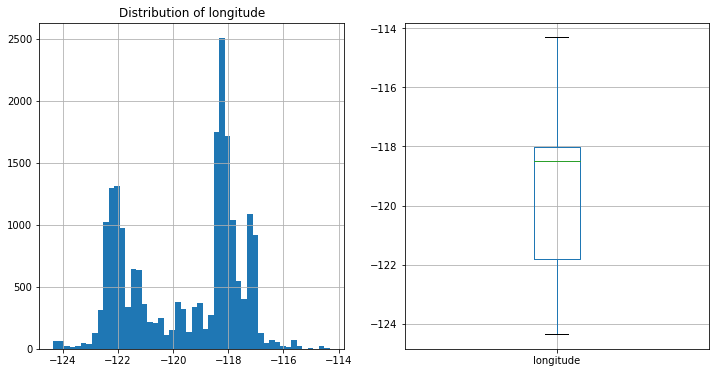

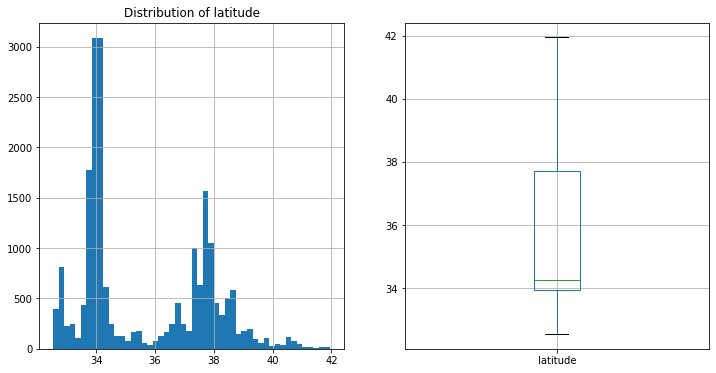

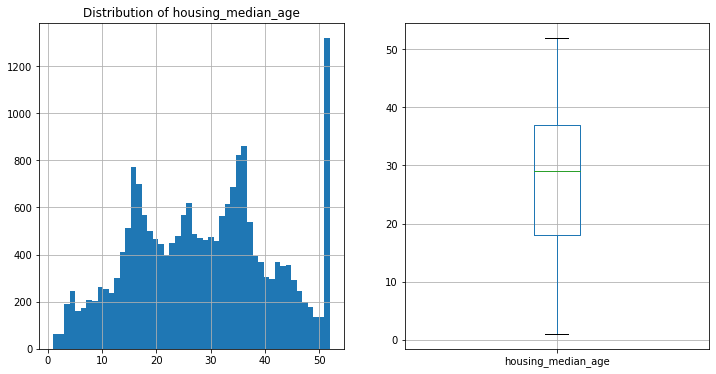

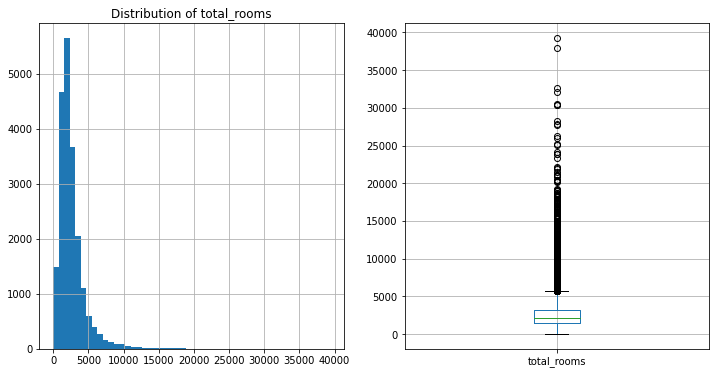

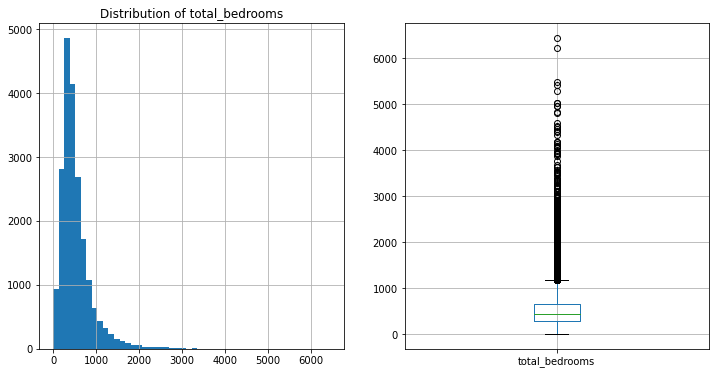

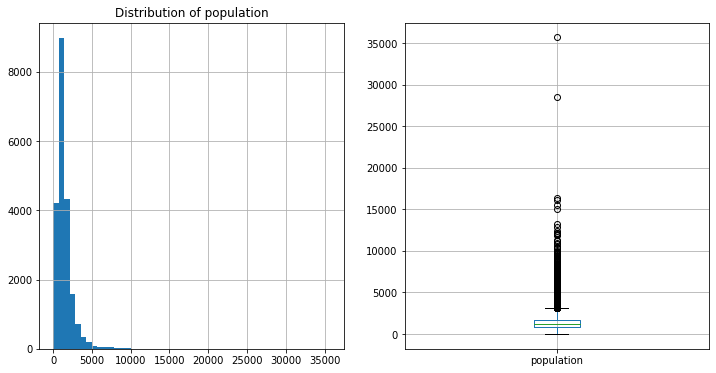

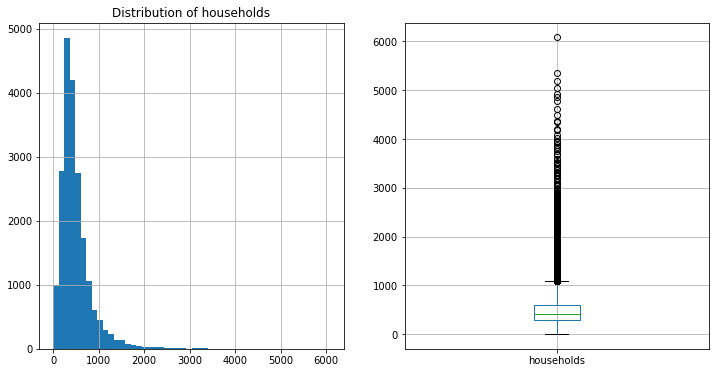

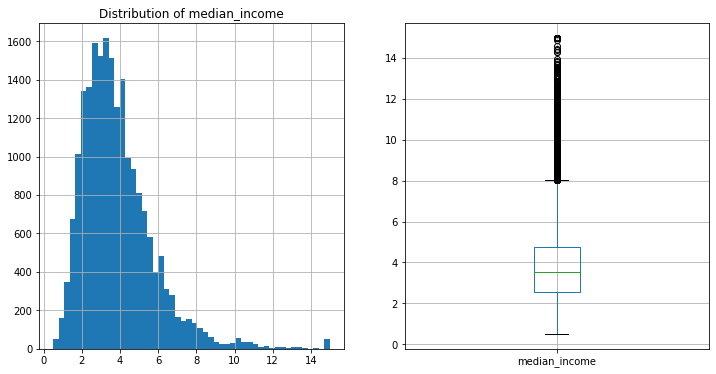

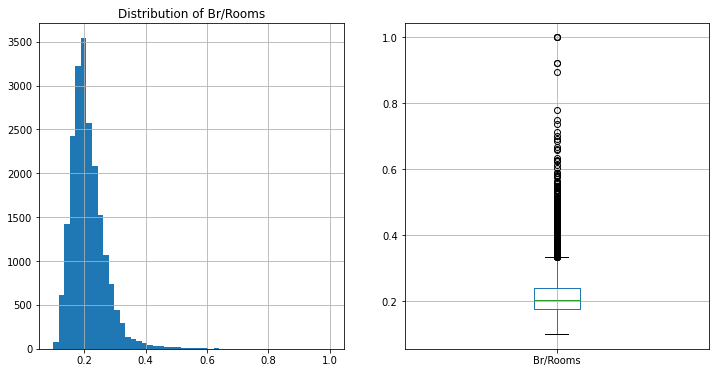

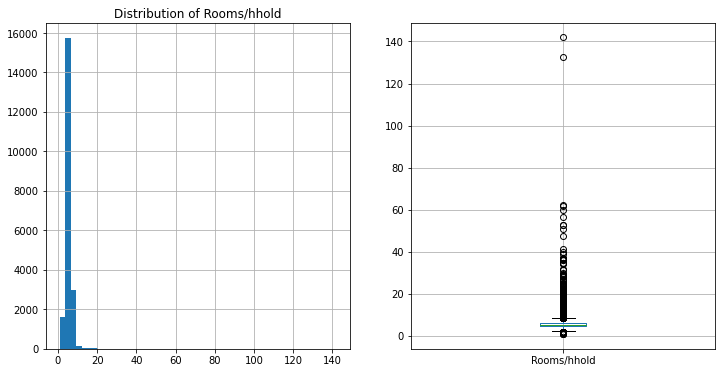

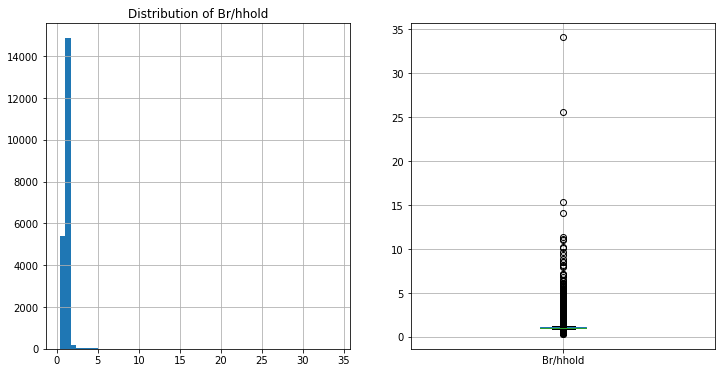

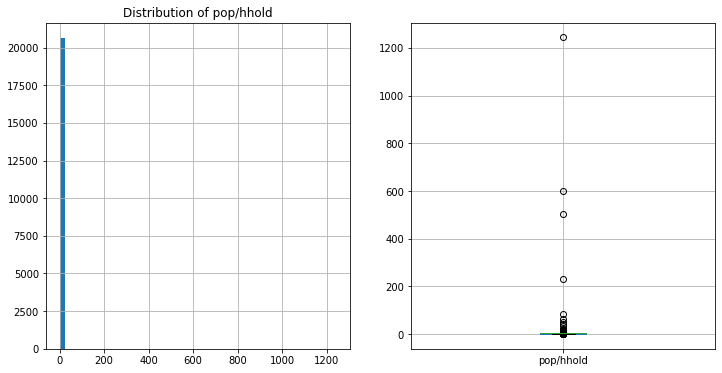

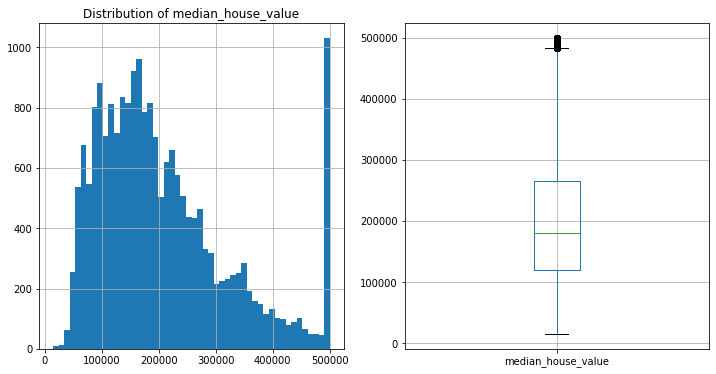

In [20]:
# 2. Call our previously defined function in 2.2.1 and pass it our dataframe to plot histograms and scatterplots of all numerical values
plot_numerics(df)

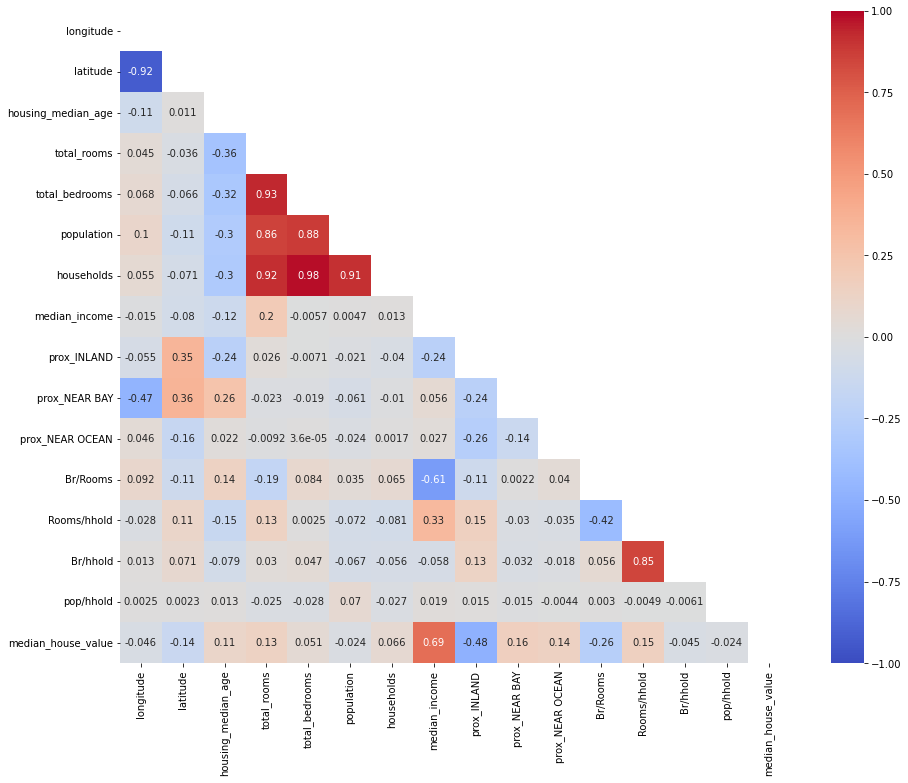

In [21]:
# 3. Let's check our variables for correlation
plt.figure(figsize=(15,12)) # if you need this correlation heatmap to be bigger
corr = df.corr()
sns.heatmap(corr,  vmin = -1, vmax = 1, center = 0, cmap = 'coolwarm', annot = True, 
            mask = np.triu(corr));  # masks upper part of triangle

In [22]:
# 4. Drop strongly correlated columns
df.drop(columns = ['total_rooms','total_bedrooms','population','households'], inplace=True)

<ipython-input-22-4860fa037934>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns = ['total_rooms','total_bedrooms','population','households'], inplace=True)


## 2.4 Preprocess the data

We are in the middle of proprocessing our data to ensure it is a suitable state for modelling.  
Let's review the common preprocessing steps:

* ***Dealing with missing values***  
   where we identify which, if, any missing data we have and how to deal with them.  
   
   For example, we may replace missing values with the mean value for that feature, or by the average of the neighboring values:  
   
    * `pandas` has a number of options for filling in missing data that is worth exploring
    * We can also use `k-nearest neighbor` to help us predict what the missing values should be, or `sklearn Imputer` function (amongst other ways)
    
    
    
* ***Dealing with categorical values***
   by converting them into a numerical representation that can be modelled.  
   
    * There are a number of different ways to do this in `sklearn` and `pandas` such as `pandas.get_dummies`  

* ***Removing outliers***
   to avoid undue influence on the analysis.  Outliers in this data come from many sources: 
   * Miscoded data (home values over 500K, age over 50 years)
   * True anomalies from how or what data was gathered (Los Angeles blocks with huge population, vacation areas with huge numbers of rooms per person)
   * Rare circumstances (homes on islands) 

* ***Scaling the data***
   to enable different features to be combined or compared, feature data may be transformed to be:
   * all on the same scale (such as within two defined values)
   * (approximately) normally distributed 
   * zero-mean
   * etc.  
   
 Not all ML models require this step, but most benefit from it.  Again, `sklearn` and `pandas` have in-built functions to help you do this.

 Finally, we split into Train and Test data, and hide the Test data from any model building efforts. 

### 2.4.1 Outlier Removal

Houses over 50 years old or over $500K will not have those parameters accurately recorded, so we should not use them for training or testing. 
We can also make a function to identify outliers that are at least three standard deviations from the mean. 

In [23]:
# 1. Let's keep only records with housees under 50 years of age and a value under $500K
print(df.shape)
df = df[(df.housing_median_age <= 50) & (df.median_house_value <=500000)]
print(df.shape)

(20635, 12)
(18526, 12)


In [24]:
# 2. This function can be used on a list of numerical columns to return a list of index values of the outliers 
def get_outliers(data, columns, nsd = 3): 
    """ Takes a data frame and list of numeric columns names, return the list of indices for which 
    a value in any of the columns is more than nsd standard deviations from the column mean."""
    outlier_idxs = []
    for col in set(data.columns).intersection(set(columns)):
        elements = data[col]
        # we get the mean value for each column
        mean = elements.mean()
        # and the standard deviation of the column
        sd = elements.std()
        # we then get the index values of all values higher or lower than the mean +/- nsd standard deviations
        outliers_mask = data[(data[col] > mean + nsd*sd) | (data[col]  < mean  - nsd*sd)].index
        # and add those index values to our list
        outlier_idxs  += [x for x in outliers_mask]
    return list(set(outlier_idxs))

Define the columns where we have identified there could be outliers, in the order you'd like them removed. 
**? Any columns you would add?**

In [25]:
# 3. Defne column list 
numeric_columns = ['median_income','median_house_value', 'Br/Rooms', 'Br/person', 'Br/hhold', 'Rooms/person', 'Rooms/hhold', 'pop/hhold']

# 4. Let's check how many observations we have:
print (f"Number of Observations and Features before Cleaning: {df.shape}")

# 5. We call the function we just created on the housing dataset ...
outlier_list = get_outliers(df, numeric_columns)

# 6. ... and drop those records from both our feature and response data
df.drop(outlier_list, axis = 0, inplace=True)

# 7. We can check that this code has worked by looking at the shape of our data 
print (f"Number of Observations and Features after Cleaning: {df.shape}")

# WARNING - Be careful: if you repeatedly re-run this cell, you are removing more and more records!

Number of Observations and Features before Cleaning: (18526, 12)
Number of Observations and Features after Cleaning: (17894, 12)


<ipython-input-25-6d74d6844f7c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(outlier_list, axis = 0, inplace=True)


### 2.4.2 Re-Scale the Data

We can create a function to rescale our data so that the mean is zero and standard deviation is unity (1) on all features.  

Lets look at the data before and after re-scaling.  

**!** A good exercise would be to research what StandardScaler does - it is from the scikit-learn library.

In [26]:
# 1. Check Variable distributions
df.describe()

,longitude,latitude,housing_median_age,median_income,prox_INLAND,prox_NEAR BAY,prox_NEAR OCEAN,Br/Rooms,Rooms/hhold,Br/hhold,pop/hhold,median_house_value
count,17894.000000,17894.000000,17894.000000,17894.000000,17894.000000,17894.000000,17894.000000,17894.000000,17894.000000,17894.000000,17894.000000,17894.000000
mean,-119.501457,35.602096,27.018889,3.667937,0.342573,0.084889,0.125349,0.211183,5.263745,1.068230,2.978639,186692.528166
std,1.985021,2.148210,11.362816,1.472580,0.474583,0.278724,0.331124,0.046226,1.152751,0.136347,0.875958,92158.769683
min,-124.300000,32.540000,1.000000,0.499900,0.000000,0.000000,0.000000,0.100000,1.714286,0.333333,0.750000,14999.000000
25%,-121.580000,33.920000,18.000000,2.556800,0.000000,0.000000,0.000000,0.177688,4.449164,1.004963,2.477500,114400.000000
50%,-118.460000,34.250000,27.000000,3.474050,0.000000,0.000000,0.000000,0.203015,5.203853,1.047440,2.860108,170150.000000
75%,-117.970000,37.670000,36.000000,4.590750,1.000000,0.000000,0.000000,0.238095,5.957681,1.097775,3.323529,240475.000000
max,-114.550000,41.950000,50.000000,8.404500,1.000000,1.000000,1.000000,0.378975,12.384615,2.487699,33.952941,476700.000000


In [27]:
# 2. This function loops through columns in a data set and applies the scaler to each that we passed to the function
def scale_numeric(data, numeric_columns, scaler):
    for col in numeric_columns:
        data.loc[:,col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
    return data

In [28]:
# 3. We can now define the scaler we want to use and apply it to our dataset 
scaler = StandardScaler()
numeric_columns = [col for col in df.columns if df[col].dtype == 'float64']
df = scale_numeric(df, numeric_columns, scaler)

# 4. Let's check out varible's distribution after the rescaling
df.describe()

<ipython-input-27-cc3864216b4e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,col] = scaler.fit_transform(data[col].values.reshape(-1, 1))


,longitude,latitude,housing_median_age,median_income,prox_INLAND,prox_NEAR BAY,prox_NEAR OCEAN,Br/Rooms,Rooms/hhold,Br/hhold,pop/hhold,median_house_value
count,1.789400e+04,1.789400e+04,1.789400e+04,1.789400e+04,17894.000000,17894.000000,17894.000000,1.789400e+04,1.789400e+04,1.789400e+04,1.789400e+04,1.789400e+04
mean,1.346910e-15,-1.467624e-15,9.530024e-17,1.778938e-16,0.342573,0.084889,0.125349,3.049608e-16,4.447345e-17,1.028448e-15,2.708115e-16,-6.353350e-17
std,1.000028e+00,1.000028e+00,1.000028e+00,1.000028e+00,0.474583,0.278724,0.331124,1.000028e+00,1.000028e+00,1.000028e+00,1.000028e+00,1.000028e+00
min,-2.417444e+00,-1.425457e+00,-2.289891e+00,-2.151411e+00,0.000000,0.000000,0.000000,-2.405260e+00,-3.079208e+00,-5.390033e+00,-2.544301e+00,-1.863071e+00
25%,-1.047143e+00,-7.830440e-01,-7.937417e-01,-7.545720e-01,0.000000,0.000000,0.000000,-7.245957e-01,-7.066614e-01,-4.640272e-01,-5.721201e-01,-7.844565e-01
50%,5.246729e-01,-6.294235e-01,-1.662400e-03,-1.316683e-01,0.000000,0.000000,0.000000,-1.767042e-01,-5.195796e-02,-1.524803e-01,-1.353189e-01,-1.795053e-01
75%,7.715287e-01,9.626439e-01,7.904169e-01,6.266817e-01,1.000000,0.000000,0.000000,5.822083e-01,6.019989e-01,2.166934e-01,3.937406e-01,5.836013e-01
max,2.494481e+00,2.955056e+00,2.022540e+00,3.216596e+00,1.000000,1.000000,1.000000,3.629909e+00,6.177458e+00,1.041097e+01,3.536147e+01,3.146912e+00


### 2.4.3 Split the Data into X and y, and Train and Test sets
* In order to train our model and see how well it performs, we need to split our data into training and testing sets.  

* We can then train our model on the training set, and test how well it has generalised to the data on the test set.  

* There are a number of options for how we can split the data, and for what proportion of our original data we set aside for the test set.

In [29]:
# 1. Split out Xs and Ys
housing_y = df['median_house_value'].values
housing_X = df.drop(columns=['median_house_value'])

# 2. A common way for splitting our dataset is using train_test_split 
X_train, X_test, y_train, y_test = model_selection.train_test_split(housing_X, housing_y, test_size = 0.2, random_state = 42)

# 3. Get shape of test and training sets
print('Training Set:')
print('Number of records: ', X_train.shape[0])
print('Number of features: ', X_train.shape[1])
print('\n')
print('Test Set:')
print('Number of records: ', X_test.shape[0])
print('Number of features: ', X_test.shape[1])

Training Set:
Number of records:  14315
Number of features:  11


Test Set:
Number of records:  3579
Number of features:  11


# 3. Regression Analysis for Prediction
Derived from a notebook accompanying "Classification and Regression in a Weekend" by Ajit Jaokar & Dan Howarth (With contributions from Ayse Mutlu), published by Data Science Central. 
Their original notebook is here: https://colab.research.google.com/drive/14m95e5A3AtzM_3e7IZLs2dd0M4Gr1y1W

##  3.1 Linear regression

Linear regression is simple model compared to more complicated regression options, so provides a good baseline.

**Regression Mechanics:**  

y = ax + b
  - y = target (response)  
  - x = single feature  
  - a, b = parameters of model  
  
How do we choose a and b?
  - Define an error function for any given line
  - Choose the line that minimizes the error function
  
**The Loss Function**

Ordinary least squares (OLS): Minimize sum of squares of
residuals

![OLS Loss Function Residuals](https://www.mapxp.app/BUSI488/OLS-residual.jpg "OLS Loss Function")


### 3.1.1 Let's run an OLS on our housing Housing Data!
We start with a single feature, median_income

In [30]:
# 1. We pull out only one varibale, median_income, from our X_train and X_test sets (which include all variables)
X_income_train = X_train['median_income'].values
X_income_test = X_test['median_income'].values

# 2. Instantiate model: In scikit-learn you create a model separate from your data, which allows you to swap in other models (or data) with minimal code changes
lm = LinearRegression()

# 3. Fit model: we train the model on our training data. Fitting requires both X and y variables for training. 
# Because we have only one colum, we reshape it into the format that the linear regressor expects
lm.fit(X_income_train.reshape(-1,1), y_train)

LinearRegression()

### 3.1.2 Prediction and Performance

Now that we have fit our model, we can use it to predict our response variable in the test set...  
... and check how well our model performed!

In [31]:
# 1. Predict: We  generate a set of predictions on our unseen features X_test
y_pred = lm.predict(X_income_test.reshape(-1,1))

#### Choose an evaluation metric
* We then need to compare these predictions with the actual result and measure them in some way.  


* This is where the selection of evaluation metric is important. For regression, we measure the distance between the predicted and actual answers in some way. The shorter the distance, the more correct the model is.   


* We cover three common metrics below:  
  
  * `Mean Absolute Error`: which provides a mean score for all the predicted versus actual values as an absolute value   
  
  * `Means Squared Error`: which provides a mean score for all the predicted versus actual values as a square of the absolute value  
  
  * `R2`: which we recommend you research as an exercise to grow your knowledge. WIkipedia and `sklearn` document are a great place to start!  

Mean squared error:  0.5466817901313296
Mean absolute error:  0.5667558345314644
R^2 :  0.44697722486602376


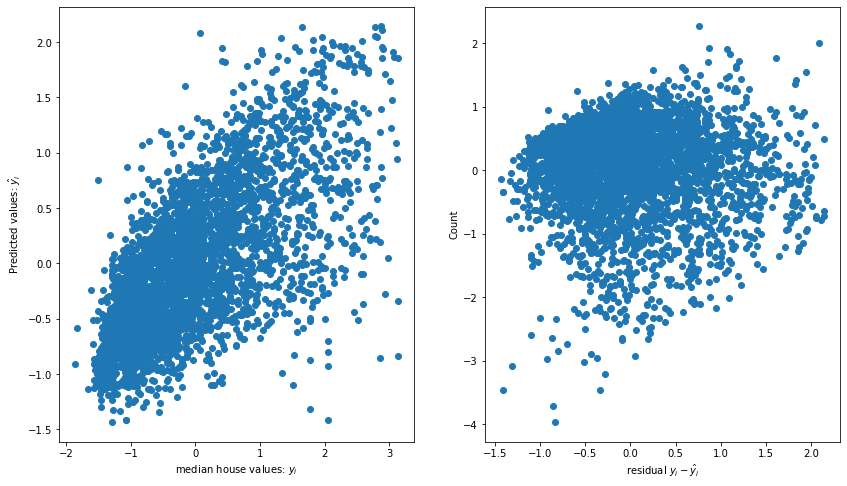

In [32]:
# 2. Import a library that we will need for our evaluation metrics
from scipy.stats import norm

# 3. Define a function that evaluates our predictions (y_pred) relative to the ground truth (i.e., y_test)
def evaluate(y_test, y_pred, viz=True):
    # this block of code returns all the metrics we are interested in 
    mse = metrics.mean_squared_error(y_test, y_pred)
    msa = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)

    print("Mean squared error: ", mse)
    print("Mean absolute error: ", msa)
    print("R^2 : ", r2)
    if viz==True:
      # this creates a chart plotting predicted and actual with distribution of residual 
      f, axes = plt.subplots(1, 2, figsize=(14, 8))
      axes[0].scatter(y_test, y_pred)
      axes[0].set(xlabel="median house values: $y_i$", ylabel="Predicted values: $\hat{y}_i$")
      #plt.title("Prices vs Predicted values: $y_i$ vs $\hat{y}_i$")
      axes[1].scatter(x=y_pred, y=y_pred-y_test, ) 
      axes[1].set(xlabel="residual $y_i-\hat{y}_i$", ylabel="Count", label='resid')
  
 # 4. Pass the ground truth (y_test) and our predictions (y_pred) to our evaluation function
evaluate(y_test, y_pred, viz=True)

## 3.1.3 Multilinear regression
OLS can use more input variables to get a better prediction

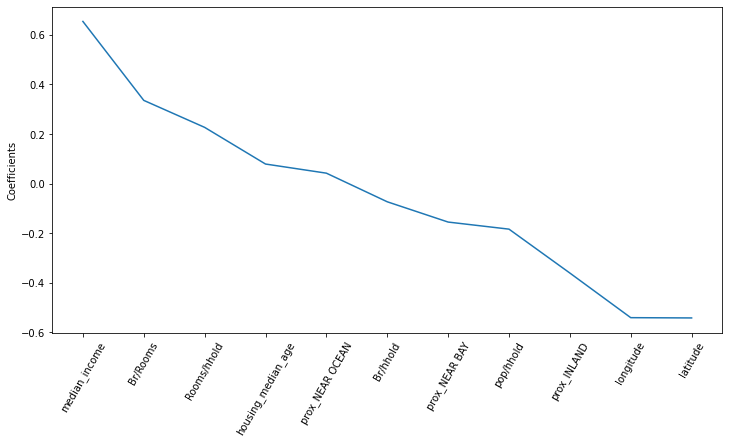

In [33]:
# 1. Instantiate model
lm = LinearRegression()

# 2. Fit model to full set of variables
lm.fit(X_train, y_train)

# 3. let's save the coefficients and plot them large to small
linear1_coeff = lm.coef_.copy()
coeff_perm = np.flipud(np.argsort(linear1_coeff))

# 4. Plot coefficients
plt.figure(figsize=(12,6))
plt.plot(linear1_coeff[coeff_perm])
plt.ylabel('Coefficients')
plt.xticks(range(housing_X.columns.size), housing_X.columns.values[coeff_perm], rotation=60)
plt.show()

In [34]:
# 5. Use our trained model to predict the median house values in the test set
y_pred = lm.predict(X_test)

Mean squared error:  0.3520010768449
Mean absolute error:  0.4365280245134776
R^2 :  0.6439160479075949


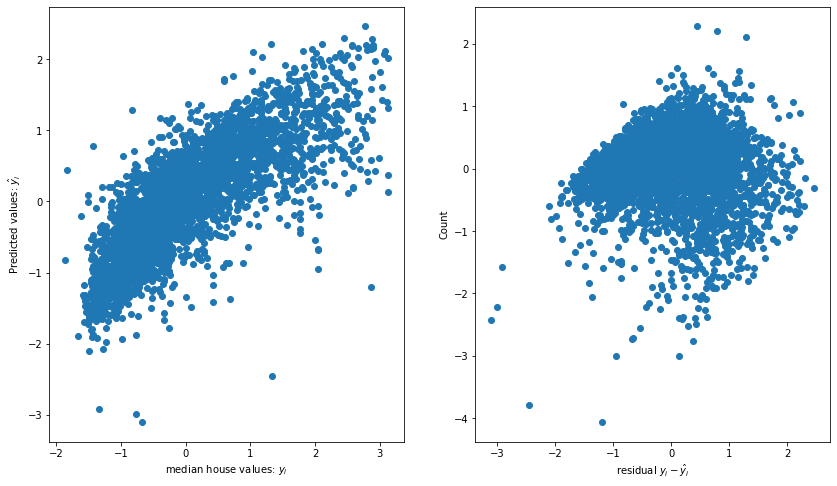

In [35]:
# 6. Evaluate model performance
evaluate(y_test, y_pred, viz=True)

In [36]:
#### BONUS ####
# We can explore how metrics are derivied in a little more detail by looking at MAE
# here we will implement MAE using numpy, building it up step by step

# 7a. With MAE, we get the absolute values of the error - as you can see this is of the difference between the actual and predicted values
np.abs(y_test - y_pred)

# 7b. We sum them up 
np.sum(np.abs(y_test - y_pred))

# 7c. then divide by the total number of predictions/actual values
# as you will see, we get to the same score implemented above 
print (np.sum(np.abs(y_test - y_pred))/len(y_test))

0.4365280245134776


#### 3.1.3.1 YellowBrick 
- YellowBrock is a visualization tool for sklearn models, built on top of matplotlib/seaborn.  
- It enables you to easily and quickly explore the performance of different models
- https://www.scikit-yb.org/en/latest/index.html 

In [37]:
# 0. Let's install yellowbrick
# !pip install yellowbrick

# 1. Import some libraries
from yellowbrick.regressor import residuals_plot

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


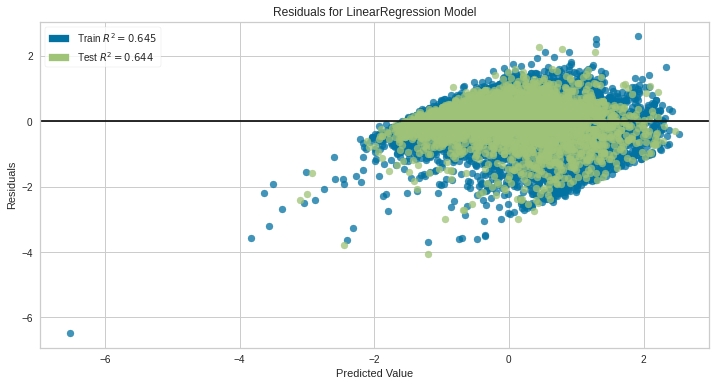

In [38]:
# 2. Use YellowBrick to plot residuals for our original LM model
plt.figure(figsize=(12,6))
# 2b. Fit and plot with yellowbrick
viz = residuals_plot(lm, X_train, y_train, X_test, y_test,  hist=False, qqplot=False)
plt.show()

### 3.1.4 Refine the model
* This step allows us to add or modify features of the datatset. We might do this if, for example, some combination of features better represents the problems space and so is an indicator of the target variable. 
* Here, we create one additional feature as an example, but you should reflect on our EDA earlier and see whether there are other features that can be added to our dataset.
* The feature we add is **the log of an existing feature,** so we fit a non-linear model.
* There are other transformations or other algorithms that can fit other non-linear models into this linear framework.  Think about your data to decide what model would work well.  
   
![Types of regression](https://storage.ning.com/topology/rest/1.0/file/get/952937562?profile=original)


In [39]:
# 0. Go back to dataset before we did out previous preprocessing
log_df = df_preFE.copy() # Restore all fields

# 0a. Missing data: replace nans in total_bedrooms by imputing them to be 20% of all rooms
log_df.loc[log_df['total_bedrooms'].isna(), 'total_bedrooms'] = 0.20*log_df['total_rooms']

# 0b. Remove older houses and those bucketed to $500K
log_df = log_df[(log_df.housing_median_age <= 50) & (log_df.median_house_value <=500000)]

In [40]:
# 1. Engineer some additional features. 
# (Comment out or drop features you don't want to add)

log_df['Br/Rooms'] = log_df['total_bedrooms']/log_df['total_rooms']
#log_df['Rooms/person'] = log_df['total_rooms']/log_df['population']
log_df['Rooms/hhold'] = log_df['total_rooms']/log_df['households']
#log_df['Br/person'] = log_df['total_bedrooms']/log_df['population']
log_df['Br/hhold'] = log_df['total_bedrooms']/log_df['households']
log_df['pop/hhold'] = log_df['population']/log_df['households']

In [41]:
#### Someone on Kaggle suggested using log to transform skew distributions: https://www.kaggle.com/ilialar/california-housing-analysis-and-preciction 

# 2. Define skewed features
skewed_features=['households','median_income','population', 'total_bedrooms', 'total_rooms']

# 3. Keep the names of the log features we will create
log_numerical_features=[]

# 4. Create log features
for f in skewed_features:
    log_df[f + '_log']=np.log1p(log_df[f])
    log_numerical_features.append(f + '_log')

# 5. Drop skewed features
log_df.drop(columns=skewed_features, inplace=True)

In [42]:
# 6. Remove outliers with previously defined function
numeric_columns = [col for col in log_df.columns if log_df[col].dtype == 'float64']
outlier_list = get_outliers(log_df, numeric_columns)

# 7. and drop those records from both our feature and response data
log_df.drop(outlier_list, axis = 0, inplace=True)

In [43]:
# 7. Let's scale all numeric columns
scaler = StandardScaler()
numeric_columns = [col for col in log_df.columns if log_df[col].dtype == 'float64']
log_df = scale_numeric(log_df, numeric_columns, scaler)

In [44]:
# 8. Split out dependent variable (y) and independent variables (X)
log_y = log_df['median_house_value'].values
log_X = log_df.drop(columns=['median_house_value'])

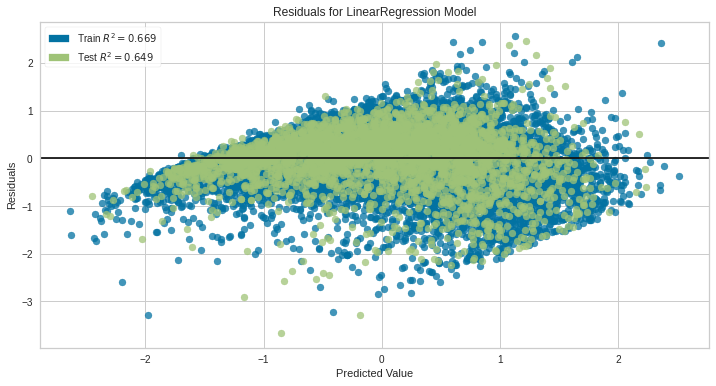

In [45]:
# 9. Train-Test-Split our Sample
logX_train, logX_test, logy_train, logy_test = model_selection.train_test_split(log_X, log_y, test_size = 0.2, random_state=0)

# 10. Instantiate Model
loglm = LinearRegression()

# 11. Use YellowBrick to fit model and output Performance
plt.figure(figsize=(12,6))
viz = residuals_plot(loglm, logX_train, logy_train, logX_test, logy_test,  hist=False, qqplot=False)
plt.show()

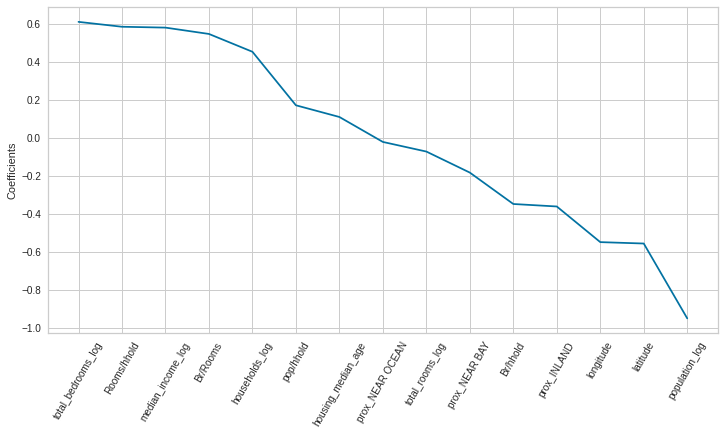

In [46]:
# 12. let's save the coefficients and plot them large to small
linear2_coeff = loglm.coef_.copy()
coeff_perm = np.flipud(np.argsort(linear2_coeff))

# 13. Plot coefficients
plt.figure(figsize=(12,6))
plt.plot(linear2_coeff[coeff_perm])
plt.ylabel('Coefficients')
plt.xticks(range(log_X.columns.size), log_X.columns.values[coeff_perm], rotation=60)
plt.show()

# 4. Regularization

**Recall:** Linear regression minimizes a loss function
- It chooses a coefficient for each feature variable
- Large coefficients can lead to overfitting
- Penalizing large coefficients is called Regularization


In statistics, there are two critical characteristics of estimators to be considered: 
- ***Bias*** is the difference between the true population parameter and the expected estimator
  - It measures the accuracy of the estimates
- ***Variance*** measures the spread, or uncertainty, in these estimates

**Remember:**
- Bias and the variance are desired to be low, as large values result in poor predictions from the model.
- The OLS estimator has the desired property of being unbiased. 
- However, it can have a huge variance.

![from KDnuggets](https://www.mapxp.app/BUSI488/bias-variance-tradeoff.jpg "Bias-Variance Trade-Off")


**Solution**: Reduce variance at the cost of introducing some bias.
- This approach is called **regularization** and is almost always beneficial for the predictive performance of the model. 

**Principle:**
- Regularization adds a penalty when coefficients get too large in an attempt to reduce the impact of outliers and make models that better predict new values for samples that have not been seen before. 
- Important techniques are ridge, lasso, and their combination as elastic net. 
- Each has a hyperparameter ($\alpha$) for the size of the penalty
- We will tune these hyperparameters later in this lecture.

**Rather than go into further details on these techniques, we will apply them to improve model performance!**

If you would like further details you might want to look at DataCamp's excellent tutorial:
[Regularization tutorial](https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net)




## 4.1 Ridge Regression

**Basic Idea:**

- Some predictors may not be as important for out model and we could reduce model complexity by removing them all together.   


- Removing predictors from the model can be seen as settings their coefficients to zero.   


- Instead of forcing them to be exactly zero, let's penalize them if they are too far from zero, thus enforcing them to be small in a continuous way.   


- This way, we decrease model complexity while keeping all variables in the model.  



**Mechanics:**

- Loss function = OLS loss function $+  \alpha \times \sum_{i=1}^n a_i^2$


- Alpha ($\alpha$ ): Parameter we need to choose  


- Picking $\alpha$ here is similar to picking k in k-NN  


- Hyperparameter tuning next section of this notebook  


- $\alpha$ controls model complexity  


- $\alpha$ = 0: We get back OLS (Can lead to overfitting)  


- Very high $\alpha$: Can lead to underfitting

- Assumes the features are standardized and response is centered 

**Let's run a ridge regression on our housing Housing Data!**

In [47]:
# 1. Import Model
from sklearn.linear_model import Ridge

# 2. Instantiate Model
ridge = Ridge(alpha=.1)

# 2. Fit Model
ridge.fit(logX_train, logy_train)

# 3. Predict Text
ridge_pred = ridge.predict(logX_test)

# 4. Evaluate Model Performance
ridge.score(logX_test, logy_test)

0.6488903164304751

### 4.1.2 The Effect of Changing Alpha in a Ridge Regression

So how will changes of Alpha impact the effect sizes (of the features) as expresseed by their coefficients?

**Let's try various values for alpha and see!**

In [48]:
# 1. Define Base model
lm = Ridge(alpha=0)
lm.fit(logX_train, logy_train)

# 2. Create dataframe for our test
ridge_df = pd.DataFrame({'variable': log_X.columns, 'estimate': lm.coef_})
ridge_train_pred = []
ridge_test_pred = []

# 3. Set range of alphas to test
alphas = np.arange(0, 200, 5)

# 4. Create a loop that runs ridge regression with every value of alpha we specified above
for alpha in alphas:
    lm = Ridge(alpha=alpha)
    lm.fit(logX_train, logy_train)
    var_name = 'estimate' + str(alpha)
    ridge_df[var_name] = lm.coef_
    # prediction
    ridge_train_pred.append(lm.predict(logX_train))
    ridge_test_pred.append(lm.predict(logX_test))

# 5. Consolidate results to prepare to plot
ridge_df = ridge_df.set_index('variable').T.rename_axis('estimate').rename_axis(None, axis=1).reset_index()

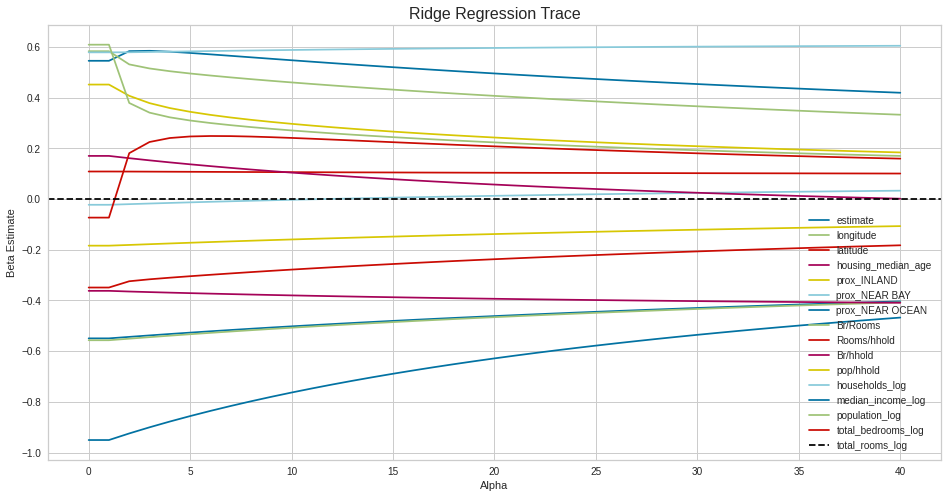

In [49]:
# 6. Plot coefficients for all alphas    

fig, ax = plt.subplots(figsize=(16, 8))
ridge_df.plot(ax=ax)
ax.axhline(y=0, color='black', linestyle='--')
ax.set_xlabel("Alpha")
ax.set_ylabel("Beta Estimate")
ax.set_title("Ridge Regression Trace", fontsize=16)
ax.legend(labels=ridge_df.columns)
ax.grid(True)

## 4.2 LASSO Regression

- Can be used to select important features of a dataset
- Shrinks the coefficients of less important features to exactly 0

Lasso adds a penalty $\alpha$ times the sum of the absolute value of the $a$ parameters.  

Doing so allows many **parameters that are not needed** in the fitting to be driven to zero.  

Thus, we find out which parameters are necessary for the model.  


**Mechanics:**

- Loss function = OLS loss function $+  \alpha \times \sum_{i=1}^n \left\lvert a_i \right\rvert$


- Alpha ($\alpha$ ): Parameter we need to choose  


- Picking $\alpha$ here is similar to picking k in k-NN  


- Hyperparameter tuning next section of this notebook  


- $\alpha$ controls model complexity  


**Let's run it on our housing Housing Dataset!**


In [50]:
# 1. Import Model
from sklearn.linear_model import Lasso

# 2. Create placeholder for fittet coefficients 
lasso_list = {}

# 3. Loop through values of alpha
for a in [0.01, 0.025, 0.05, 0.075, 0.1, 0.5, 1]:
  # instatiate
  lm = Lasso(alpha = a)
  # fit
  lm.fit(logX_train, logy_train)
  # predict
  y_pred = lm.predict(logX_test)
  print(f'alpha = {a}:')
  # evaluate
  print(lm.score(logX_test, logy_test))
  #evaluate(logy_test, y_pred)
  # Store coefficients
  lasso_list[a] = lm.coef_.copy()

alpha = 0.01:
0.6241322094819672
alpha = 0.025:
0.5987491525967248
alpha = 0.05:
0.5808533913716045
alpha = 0.075:
0.5566294991905734
alpha = 0.1:
0.5308291109883783
alpha = 0.5:
0.19639823299930037
alpha = 1:
-0.00023038060275526462


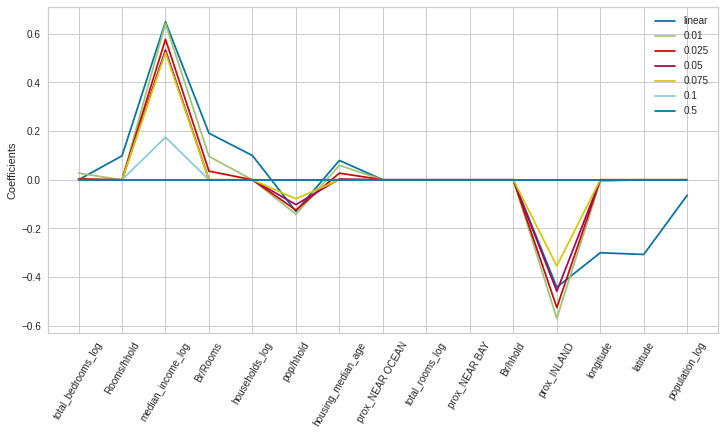

In [51]:
# 4 Plot effect on coefficient for different alphas in Lasso Regression
plt.figure(figsize=(12,6))
#plt.plot(linear1_coeff[coeff_perm])
#plt.plot(linear2_coeff[coeff_perm])
for item in lasso_list.values():
  plt.plot(item[coeff_perm])
plt.legend(['linear', *lasso_list.keys()])
plt.ylabel('Coefficients')
plt.xticks(range(log_X.columns.size), log_X.columns.values[coeff_perm], rotation=60)
plt.show()

# 5. Different Model: K-Nearest Neighborhood (KNN) Algorithm

> *Show me who your friends are, and I’ll tell you who you are*

The concept of K-NN can hardly be described more simply. This is an old saying, which can be found in many languages and many cultures.


**Basic idea:** Predict the value of a data point by  
- Looking at the values of the ‘k’ closest data points (local values)
- Interpolate these local values to make a prediction  

**Underlying Principle**:
- Find a predefined number (k) training samples closest in distance to a new sample that has to be classified
- The value of the new sample will be defined from these neighbors
- KNN has a fixed user defined constant for the number of neighbors which have to be determined 


![A Comparative Study of Linear and KNN Regression](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*1Fqej14RxTPp9zzQ5gKm_g.png "KNN Intuition")
*Image source: https://pub.towardsai.net/a-comparative-study-of-linear-and-knn-regression-a31955e6263d*



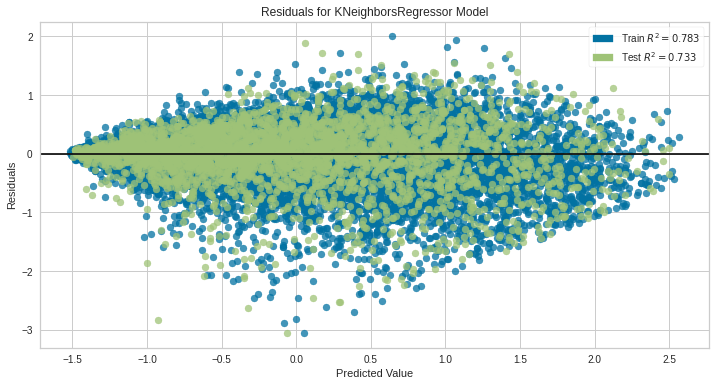

In [52]:
# 1a. Import model
from sklearn.neighbors import KNeighborsRegressor

# 1b. Train-Test-Split our Sample
logX_train, logX_test, logy_train, logy_test = model_selection.train_test_split(log_X, log_y, test_size = 0.2, random_state=42)

# 1c. Instantiate model
kn = KNeighborsRegressor(n_neighbors=7)

# 1d. Use YelloBrick to fit model, evaluate and visualize
plt.figure(figsize=(12,6))
viz = residuals_plot(kn, logX_train, logy_train, logX_test, logy_test,  hist=False, qqplot=False)
plt.show()

### 3.1.6 Location, Location, Location!

![Location!](https://everyhomeinidaho.com/wp-content/uploads/2015/02/LocationLocationLocation.png
)

Can location suffice for great predictions? 

- Linear Regression 

  vs. 
- K-NN Regression

> ***Which one do you think will work better?*** 

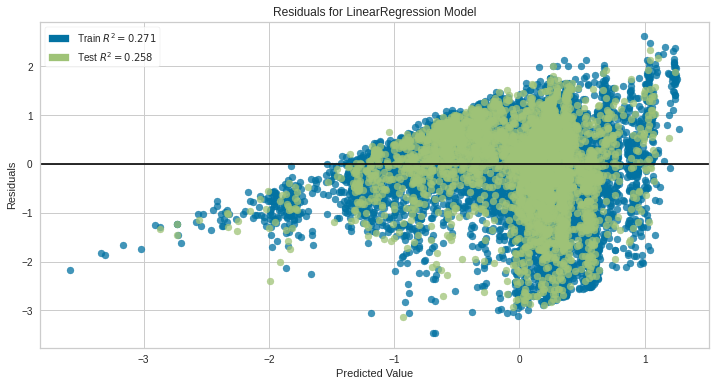

In [53]:
# 1. Location only: Linear Regression

# 1a. Train-Test-Split our Sample and define which variables to use
logX_train, logX_test, logy_train, logy_test = model_selection.train_test_split(log_X, log_y, test_size = 0.2, random_state=21)
latlon = ['latitude','longitude']

# 1b. Instantiate model
linreg = LinearRegression()

# 1c. Use YelloBrick to fit model, evaluate and visualize (we only actually use latlon = ['latitude','longitude'] as the variables)
plt.figure(figsize=(12,6))
viz = residuals_plot(linreg, logX_train[latlon], logy_train, logX_test[latlon], logy_test,  hist=False, qqplot=False)
plt.show()

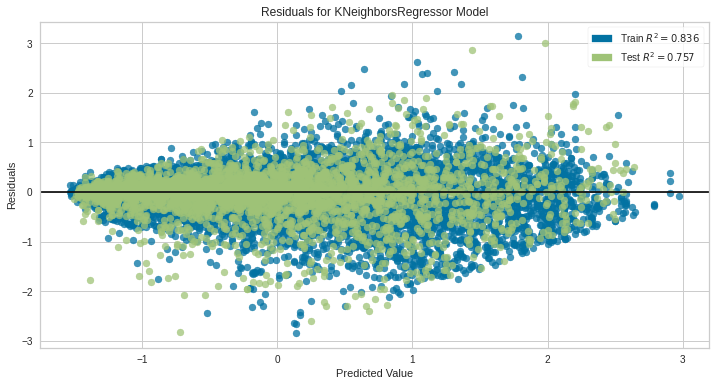

In [54]:
# 2. Location only: K-NN

# 2a. Train-Test-Split our Sample and define which variables to use
logX_train, logX_test, logy_train, logy_test = model_selection.train_test_split(log_X, log_y, test_size = 0.2, random_state=21)
latlon = ['latitude','longitude']

# 2b. Instantiate model
kn = KNeighborsRegressor(n_neighbors=7)

# 2c. Use YelloBrick to fit model, evaluate and visualize (we only actually use latlon = ['latitude','longitude'] as the variables)
plt.figure(figsize=(12,6))
viz = residuals_plot(kn, logX_train[latlon], logy_train, logX_test[latlon], logy_test,  hist=False, qqplot=False)
plt.show()

# **Looking Ahead:**  

####**Next Class:** Thursday, February 23, 2023

#### ***Predictive Modelling II:***  
   - Classification
   - Generalization Errors: Over- and Underfitting

#### **Reading** before class: none

#### ***DataCamp Homework 5*** due tonight before midnight:
Credit Risk Modeling in Python (4850 XP)

- Exploring and Preparing Loan Data 
- Logistic Regression for Defaults 
- Gradient Boosted Trees Using XGBoost








# Recap: Solving Linear Systems

Regression takes continuous numerical values from samples $X$ and estimates the values of a target variable $y$.  It is a supervised technique, used either to summarize a data set or to predict target values for new samples. 

Let's flesh out those inputs: $X$ is a matrix with $n$ rows and $k$ columns, 
so $y$ has $n$ rows:  $y_i = f(x_{i,1}, x_{i,2}, \ldots, x_{i,k})$ for $1\le i \le n$ and  
$$X = \begin{pmatrix}x_{1,1}& x_{1,2}& \ldots& x_{1,k}\\x_{2,1}& x_{2,2}& \ldots& x_{2,k}\\\vdots&\vdots&\ddots&\vdots\\x_{n,1}& x_{n,2}& \ldots& x_{n,k}\end{pmatrix}.$$  

Some intuition on solving systems of linear equations.  
* Why linear?  Because linear equations are easy to solve.  $y_1=x_{1,1}a$ has one solution, $a=y_1/x_{1,1}$, as long as $x_{1,1}\ne 0$. 
* Input: 1 sample row $X=(x_{1,1}, \ldots, x_{1,k})$, 1 target variable $y=y_1$. Output: $k+1$ parameters $a=(a_1, \ldots a_k),b$ so that $y=Xa+b= x_{1,1}a_1+x_{1,2}a_2+\cdots+x_{1,k}a_k+b$.  There are many ways to choose $a,b$ since we have more parameters than equations. E.g., set $a=0$, $b=y$.
* Input: $n=k+1$ sample rows. The equations  
$y_1=x_{1,1}a_1+x_{1,2}a_2+\cdots+x_{1,k}a_k+b$  
$y_2=x_{2,1}a_1+x_{2,2}a_2+\cdots+x_{2,k}a_k+b$  
$\qquad\vdots$  
$y_n=x_{n,1}a_1+x_{n,2}a_2+\cdots+x_{n,k}a_k+b$,
can be written as $y=Xa+b$, and solved exactly as $X^{-1}(y-b) = a$, as long as the $X$ matrix is not singular.  
* Input $n>k+1$ sample rows.  $y=Xa+b$ typically has no solutions, since there are fewer parameters than equations.  **Linear regression** suggests to  find the parameters that minimize the squared residual, $\textrm{argmin}_{a,b} (y-Xa-b)^2$.  
* Why squared?  Because to find the minimum, we look for the zeros of the derivative, which gives a **linear system** to solve for $a,b$.   
* What you will find below:
    * Looking at the values of learned parameters to see what input variables have the most effect.
    * Looking at the residuals to see if the assumptions of linear regression are satisfied. 
    * An example of non-linear regression will be handled as linear regression by adding a new columns that is a non-linear transformation of an existing column. 
    * Adding penalties to the optimization to keep parameters from getting too large (ridge), or encourage parameters to go to zero for terms that do not contribute much (lasso).
    * Hyperparameter tuning to explore which penalties give the most effective predictions. 
* Other notes:
    * For large systems, we actually compute solutions iteratively from $X$ and its diagonal, rather than working with the inverse matrix, $X^{-1}$.
    * We can also solve systems of inequalities, where we minimize $\mathbf c\cdot a$ subject to $Xa \ge b$. 
    * Constraining the solutions to be integers is much harder.

This notebook draws on  Kyoosik Kim, 2 jan 2019, https://towardsdatascience.com/ridge-regression-for-better-usage-2f19b3a202db